In [1]:
%reset -f
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import pickle
import os
import sys

sys.path.insert(0, '../../src')
import Models as models
import ModelUtils as mutils
import DataUtils as dutils

%matplotlib inline

/content/drive/MyDrive/Hankel_DMD
/content/drive/MyDrive/Hankel_DMD/examples/kuramoto


In [4]:
# ===========================================================================80
# Setup
# ===========================================================================80
# Set compute device and model precision
DEVICE, DTYPE, CDTYPE = mutils.device_setup(0, 'single')

# Saved model timestamp (folder name)
chkpt_folder = 'kur_siv_2023-05-27-1721'

# Load the model hyperparameters
hyp_fname = ''.join(['./checkpoints/', chkpt_folder, '/model_hyperparams.pkl'])
hyp = pickle.load(open(hyp_fname, 'rb'))

# Set RNG seeds
mutils.seed_model(hyp)

data_fname = f"time_coeffs_small.mat"
if os.path.exists(data_fname):
    time_coeffs_dict = loadmat('time_coeffs_small.mat')
    modes_dict = loadmat('modes_small.mat')
    time_coeffs = time_coeffs_dict['time_coeffs']
    print(np.shape(time_coeffs))
    modes = modes_dict['modes']
    np.random.shuffle(modes)
    ii_train = hyp['num_train']
    ii_test = ii_train + hyp['num_test']
    ii_val = ii_test + hyp['num_val']
    test_modes = modes[ii_train:ii_test, ...]
    
    # Make train/test/val data sets
    _, test_dataloader, _ = mutils.make_train_test(np.transpose(time_coeffs,(0, 2, 1)), hyp)
    
# Load the trained model
model_fname = ''.join(['./checkpoints/', chkpt_folder, '/trained_model'])
model = models.Hankel_DLDMD(hyp)
model.load_state_dict(torch.load(model_fname))
model.eval()
model.to(torch.device(hyp['device']))

TensorFlow version: 2.9.2
Eager execution: True
Num GPUs available: 1
Training at precision: float64
Training on device: /GPU:0


In [ ]:
# ===========================================================================80
# Run test
# ===========================================================================80
x = next(iter(test_dataloader))
results = model(x)
y, x_ae, x_adv, y_adv = dutils.host_detach_np(results)

In [12]:
recon_data = test_modes[:hyp_params['batch_size'], :, :] @ np.transpose(x_adv,(0,2,1))
actual_data = test_modes[:hyp_params['batch_size'], :, :] @ np.transpose(test_data_red,(0,2,1))
nbatch, nxpts, ntpts = np.shape(recon_data)
nobs = hyp_params['num_observables']
ysteps = hyp_params['ysteps']
dt = hyp_params['delta_t']
NT1 = hyp_params['num_time_steps']
traj_num = 10
#tvals = dt*np.arange(ysteps,NT1+ysteps-nobs)
tvals = dt*(ysteps+1) + dt*np.arange(ntpts)

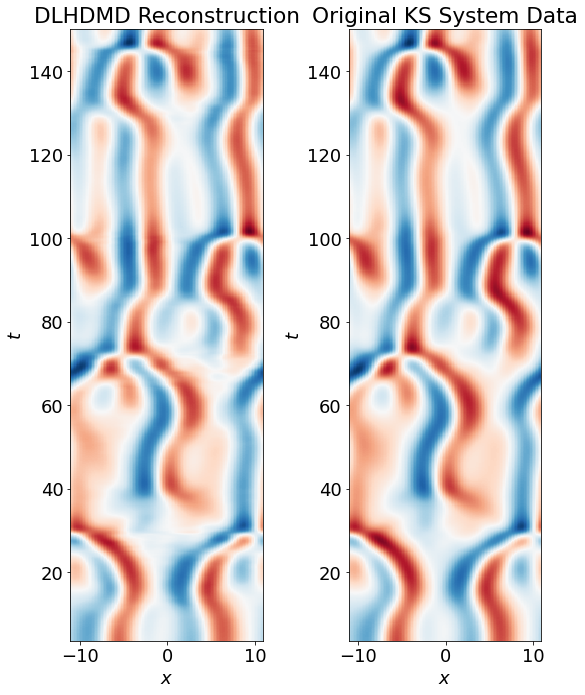

In [15]:
Xmesh = np.linspace(-11., 11., nxpts, endpoint=False)

fig = plt.figure(figsize=(8, 10))
ax = fig.add_subplot(3, 1, 1)
#ax.pcolor(Xmesh, tvals, recon_data[0,:,:].T, cmap='RdBu')
#ax.set_xlabel(r"$x$")
#ax.set_ylabel(r"$t$")
ax.pcolor(tvals, Xmesh, recon_data[0,:,:], cmap='RdBu')
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$x$")
ax.title.set_text('DLHDMD Reconstruction')
ax = fig.add_subplot(3, 1, 2)
#ax.pcolor(Xmesh, tvals, actual_data[0,:,(ysteps+1):].T, cmap='RdBu')
#ax.set_xlabel(r"$x$")
#ax.set_ylabel(r"$t$")
ax.pcolor(tvals, Xmesh, actual_data[0,:,(ysteps+1):], cmap='RdBu')
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$x$")
ax.title.set_text('Original KS System Data')
ax = fig.add_subplot(3, 1, 3)
#ax.pcolor(Xmesh, tvals, actual_data[0,:,(ysteps+1):].T, cmap='RdBu')
#ax.set_xlabel(r"$x$")
#ax.set_ylabel(r"$t$")
ax.pcolor(tvals, Xmesh, np.log10(np.abs(actual_data[0,:,(ysteps+1):]-recon_data[0,:,:])), cmap='RdBu')
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$x$")
ax.title.set_text('Error')
fig.tight_layout()
plt.savefig("KS_Dynamics_Compare", dpi=150, bbox_inches='tight')